In [274]:
from __future__ import print_function
import keras
from keras import models 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd

In [76]:
batch_size = 128
num_classes = 10
epochs = 12

In [77]:
# input image dimensions
img_rows, img_cols = 28, 28

In [150]:
# train test split 

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [151]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(10000,)


In [105]:
# class label explore

v, c = np.unique(y_train, return_counts= True)
np.asarray((v, c)).T

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

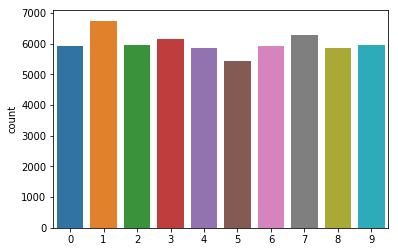

In [104]:
sns.countplot(y_train)

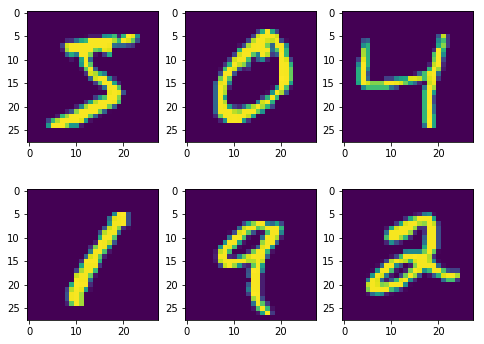

In [106]:
# show data in fig

plt.figure(figsize = (8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_train[i], interpolation = 'nearest')
plt.show()

### data processing -  normalization, one hot encode labels

In [153]:
# check which backend is used and put color channel at the correpsonding position 

# reshape the data to match Keras' expectation 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [154]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# MNIST data normalization - there are 784 inputs (28x28 pixel each) and each value is between 0-255 (single grayscale)
# dividing by 255 would put all values into the range of (0, 1)
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print(y_train.shape)
print(y_test.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(60000,)
(10000,)


In [155]:
# convert array label to one hot encoding label matrics

y_train = keras.utils.to_categorical(y_train, num_classes)
# which gives the same result as below
# y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)

(60000, 10)


### model architecture - batch normalization, adapting learning rate, data augmentation

In [131]:
model = Sequential()

# 2D convolution layer (e.g. spatial convolution over images)
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

# Max pooling operation for spatial data
model.add(MaxPooling2D(pool_size = (2, 2)))

# randomly setting a fraction of input units to 0 at each update during training time, which helps prevent overfitting.
model.add(Dropout(0.25))


# Flattens the input. Does not affect batch size
model.add(Flatten())
# Dense and fully connected layer are the same, which is a linear operation in which every input is connected to every output by a weight 
# so there are n_inputs * n_outputs weights, which simply represents a matrix vector multiplication that transforms, rotates or scales the input vector.
model.add(Dense(128, activation = 'relu'))

# batchNormalization - Normalize the activations of the previous layer at each batch,
# i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
model.add(BatchNormalization())

model.add(Dropout(0.5))

# fully connected softmax for classification output 
model.add(Dense(num_classes, activation = 'softmax'))


In [132]:
# compile before training 

model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics = ['accuracy'])

# use adapting learning rate 
# factor: factor by which the learning rate will be reduced. new_lr = lr * factor
# patience: number of epochs with no improvement after which learning rate will be reduced.

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [133]:
# data augmentation - randomly rotate, zoom, shift(fraction of total width) image

datagen = ImageDataGenerator(rotation_range = 30, zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1)

datagen.fit(x_train) # for data augmentation 

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1179776   
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
__________

In [137]:
# model training and evaluation 

# steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
# It should typically be equal to the number of samples of your dataset divided by the batch size. 

h = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),  epochs = epochs, verbose = 1, validation_data = (x_test, y_test), steps_per_epoch = x_train.shape[0]// batch_size, callbacks = [learning_rate_reduction])


Epoch 1/12
468/468 [==============================] - 152s 325ms/step - loss: 0.4515 - acc: 0.8591 - val_loss: 0.0814 - val_acc: 0.9724
Epoch 2/12
468/468 [==============================] - 145s 310ms/step - loss: 0.2025 - acc: 0.9393 - val_loss: 0.0437 - val_acc: 0.9852
Epoch 3/12
468/468 [==============================] - 139s 297ms/step - loss: 0.1611 - acc: 0.9511 - val_loss: 0.0441 - val_acc: 0.9852
Epoch 4/12
468/468 [==============================] - 144s 307ms/step - loss: 0.1370 - acc: 0.9595 - val_loss: 0.0601 - val_acc: 0.9808
Epoch 5/12
468/468 [==============================] - 140s 300ms/step - loss: 0.1260 - acc: 0.9622 - val_loss: 0.0463 - val_acc: 0.9849
Epoch 6/12
468/468 [==============================] - 146s 313ms/step - loss: 0.1194 - acc: 0.9637 - val_loss: 0.0357 - val_acc: 0.9876
Epoch 7/12
468/468 [==============================] - 147s 314ms/step - loss: 0.1099 - acc: 0.9671 - val_loss: 0.0369 - val_acc: 0.9882
Epoch 8/12
468/468 [============================

In [138]:
score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03165027916421532
Test accuracy: 0.9904


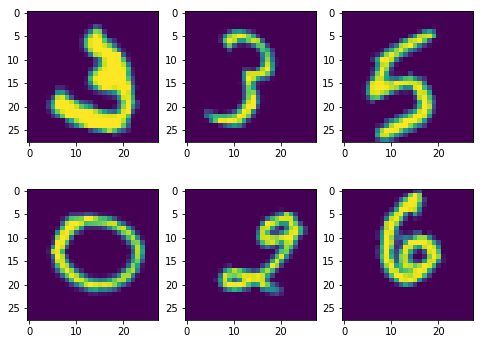

In [140]:
# see the augmented data 

plt.figure(figsize = (8, 6))
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size = batch_size):
    # visualization
    for i in range(0, 6):
        # create the grid
        plt.subplot(2, 3, i + 1)
        plt.imshow(x_batch[i].reshape(28, 28)) # cmap = plt.get_cmap('gray')
    plt.show()
    break

### evaluation visualization - classification report, val_accuracy, wrongly classified images, activation maps 

In [158]:
# for classification report

pred = model.predict_classes(x_test)


In [185]:
# np.nonzero - Returns the indices of the elements that are non-zero.

# reverse one hot encoding 
reversed_cate = np.argmax(keras.utils.to_categorical(y_test, num_classes), axis = 1)
truth = reversed_cate[reversed_cate != 0]

correct = np.nonzero(pred == truth)[0]
incorrect = np.nonzero(pred != truth)[0]


# classification report 
from sklearn.metrics import classification_report

target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(truth, pred, target_names = target_names))

             precision    recall  f1-score   support

    Class 0       0.00      0.00      0.00         0
    Class 1       1.00      0.53      0.69      2115
    Class 2       0.99      0.99      0.99      1032
    Class 3       0.99      1.00      0.99      1010
    Class 4       0.98      1.00      0.99       982
    Class 5       0.99      0.99      0.99       892
    Class 6       0.99      0.99      0.99       958
    Class 7       0.99      0.99      0.99      1028
    Class 8       0.99      0.99      0.99       974
    Class 9       1.00      0.97      0.98      1009

avg / total       0.99      0.89      0.93     10000



/Users/yueyingteng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


Text(0,0.5,'loss')

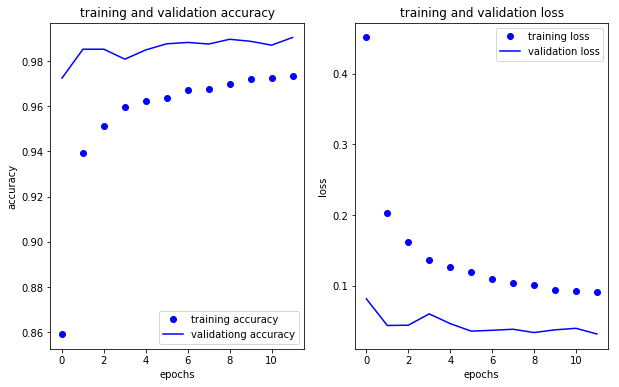

In [191]:
print(h.history.keys())

accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize = (10, 6))
plt.subplot(1 ,2 ,1)
plt.plot(epochs, accuracy, 'bo', label = 'training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'validationg accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.subplot(1 ,2 ,2)
plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [200]:
# wrongly classified images 

errors = (pred - truth != 0 )

# one hot encode predicted class for pred = model.predict(x_test)
pred_classes = keras.utils.to_categorical(pred, num_classes)

pred_classes_errors = pred_classes[errors] # one hot encoded predicted labels
pred_errors = pred[errors] # non one hot encoded preicged labels 

truth_errors = truth[errors] # non one hot encoded true label for wrongly classified images 
x_test_errors = x_test[errors] # wrongly classified images themselves 

In [271]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    # errors_index - most wrongly classified image index   
    # img_errors - the image itself
    # pred_errors - predicted label
    # obs_errors - true label
    
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
  
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]), pad = -0.5)
            n += 1


In [227]:
# prediction probability of the wrong classes 

pred_prob = model.predict_proba(x_test)

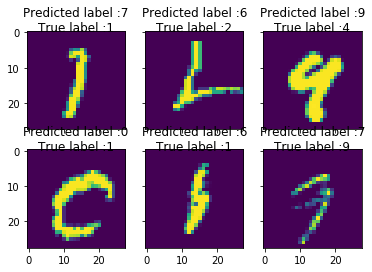

In [272]:
# get wrong probabilities 

pred_prob_errors = pred_prob[errors]

# get top 6 wrongly classifed image index
important_errors = np.argsort(1 - np.max(pred_prob_errors, axis =1))[-6:]

# plot 
display_errors(errors_index = important_errors, img_errors = x_test_errors, pred_errors = pred_errors, obs_errors = truth_errors)

https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

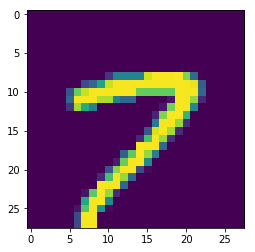

In [273]:
example = x_train[123]
plt.imshow(example.reshape((28, 28)), cmap = 'viridis', interpolation = 'none')

number of layers: 9
Tensor("conv2d_9_input:0", shape=(?, 28, 28, 1), dtype=float32)
number of intermediate output: 9
shape of the activation map from the first layer: (1, 26, 26, 32)


/Users/yueyingteng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  if __name__ == '__main__':


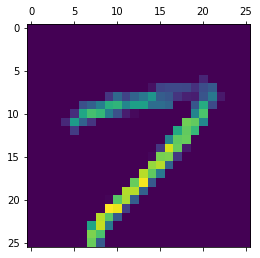

In [314]:
# show the activation map of intermediate layers by creating a new model, which will output the layers that are of interests 

# model.layers
print('number of layers: {}'.format(len(model.layers)))
print(model.input)

# create a new model to output the intermediate layers of interests 
layer_outputs = [layer.output for layer in model.layers]
intermediate_layer_model = models.Model(input = model.input, output = layer_outputs)
print('number of intermediate output: {}'.format(len(intermediate_output)))

# activation of the the first layer 
first_layer_activation = intermediate_output[0]
print('shape of the activation map from the first layer: {}'.format(first_layer_activation.shape))

# plt.matshow - Displays an array as a matrix in a new figure window.
# show the activstion of the 2nd channel of this first activation, which has 32 layers 
plt.matshow(first_layer_activation[0, :, :, 1], cmap = 'viridis')

In [287]:
# activation of the other layers 

# drop the last fully connected layer for predicting labels
model.layers[: -1]

/Users/yueyingteng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


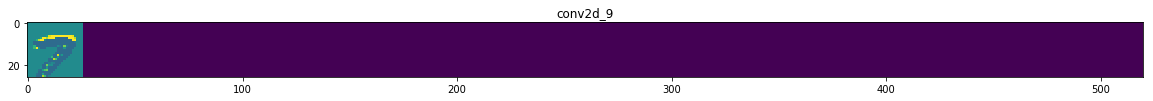

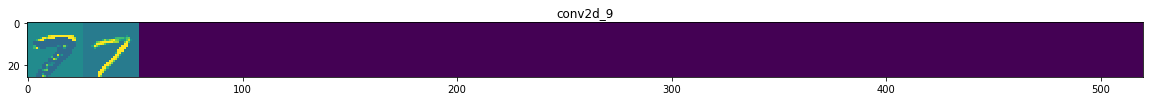

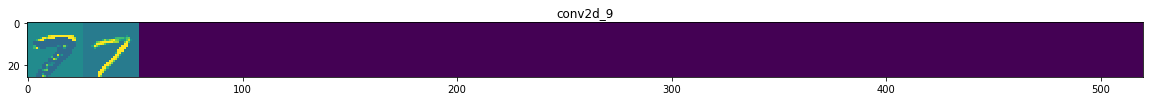

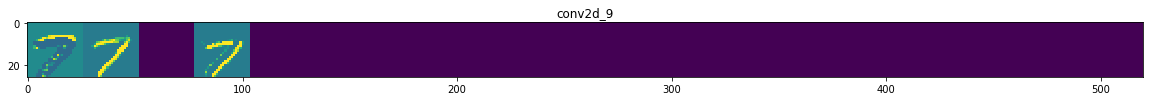

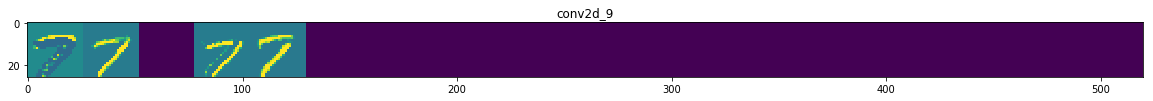

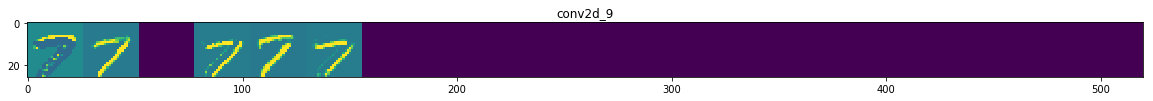

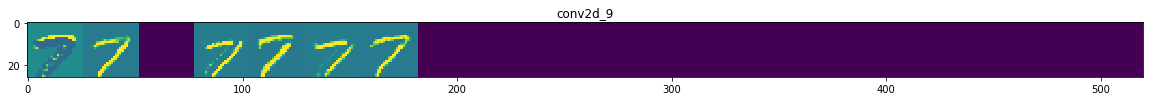

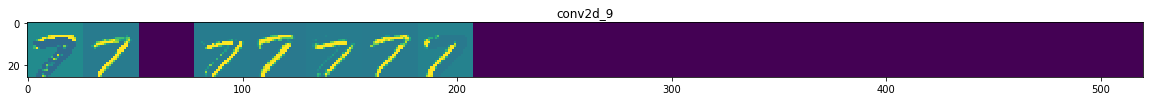

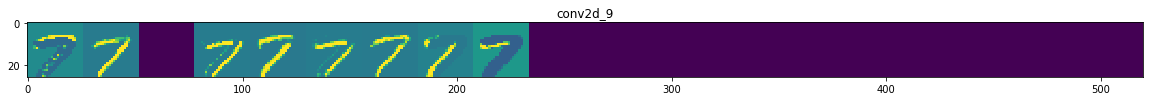

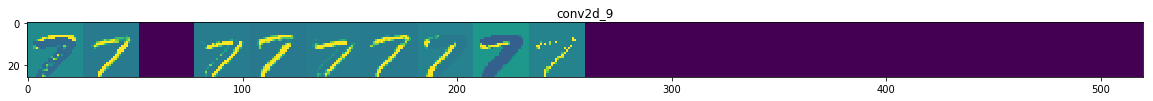

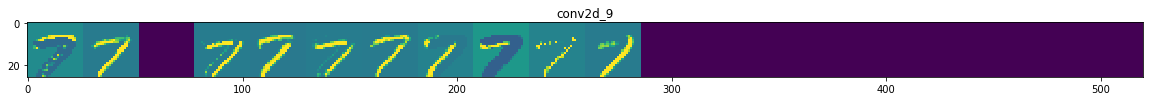

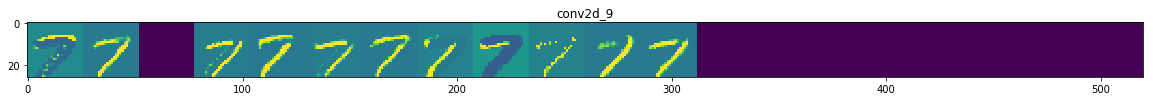

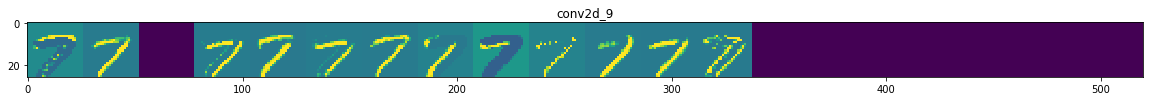

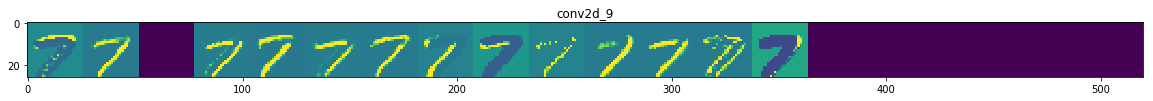

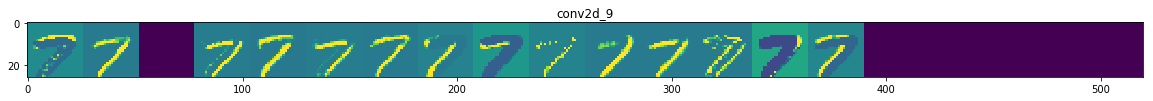

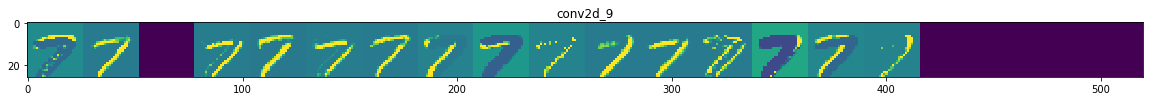

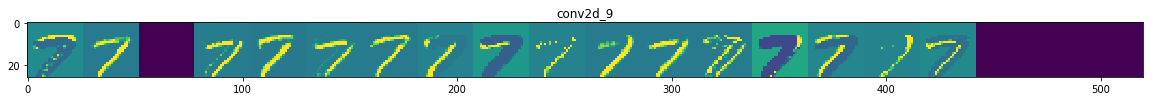

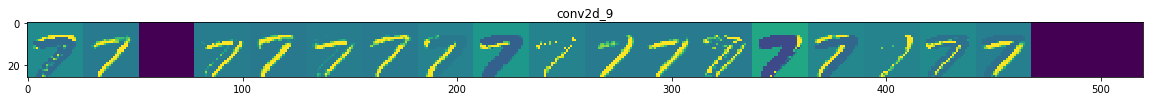

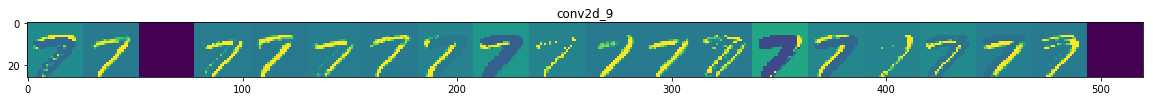

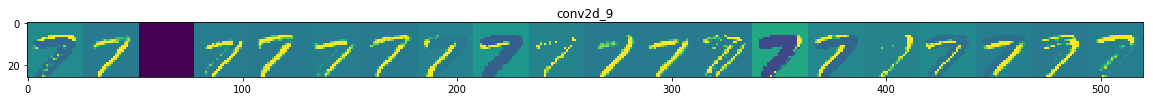

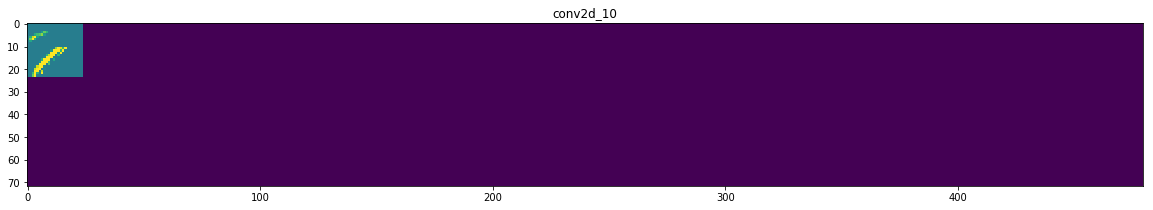

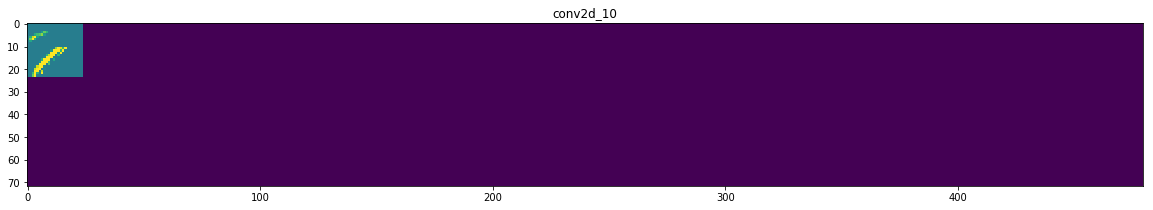

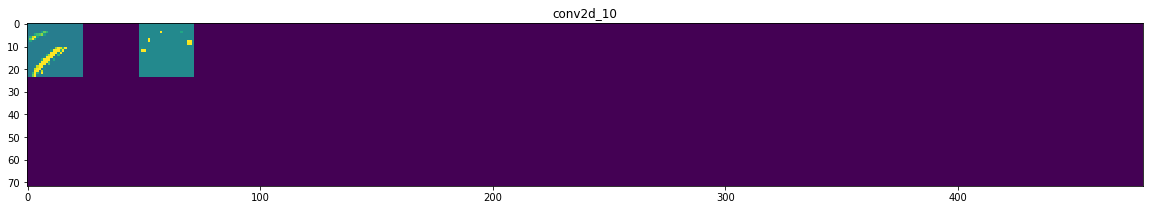

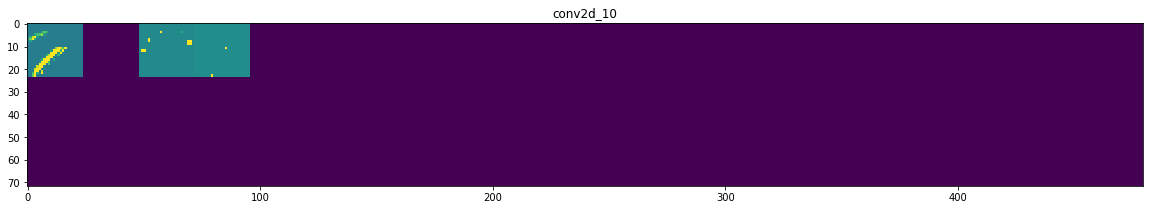

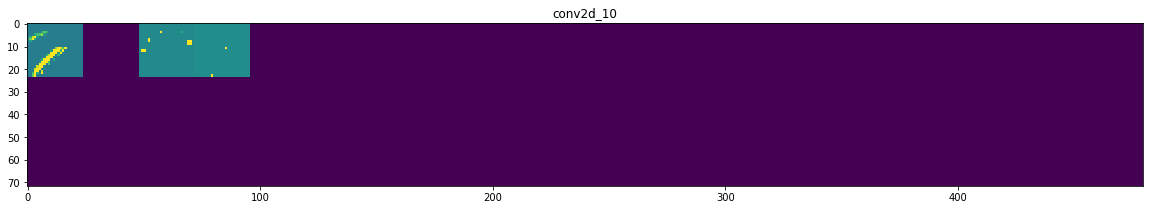

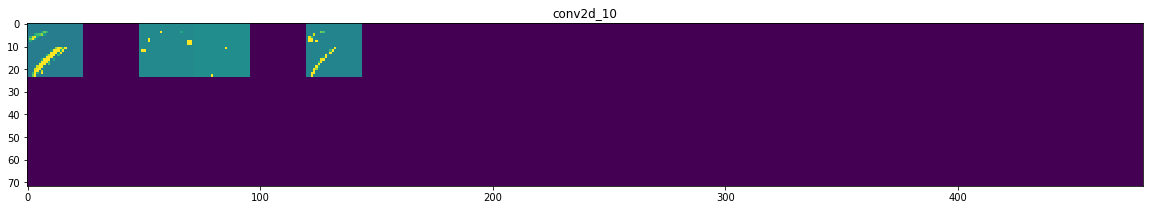

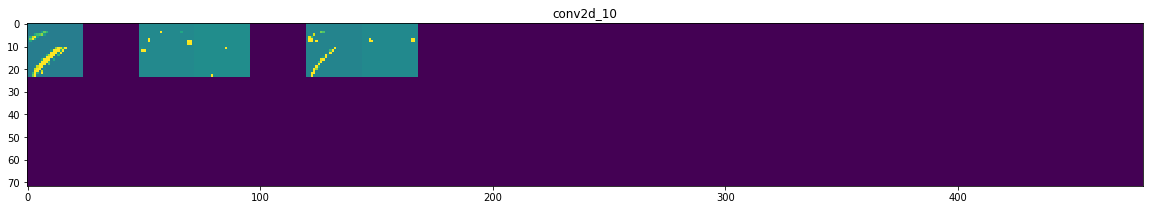

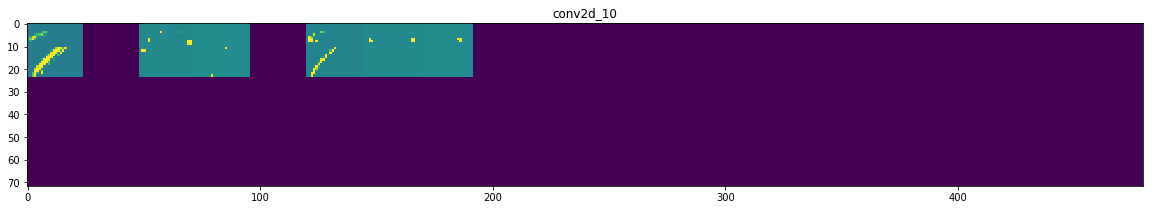

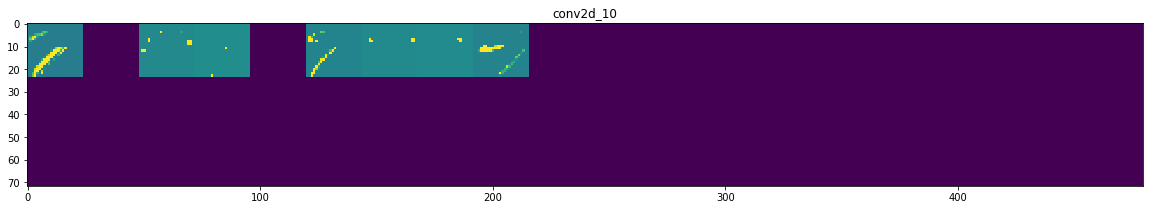

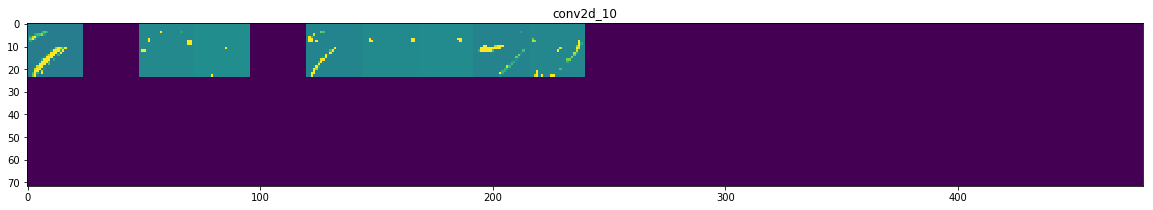

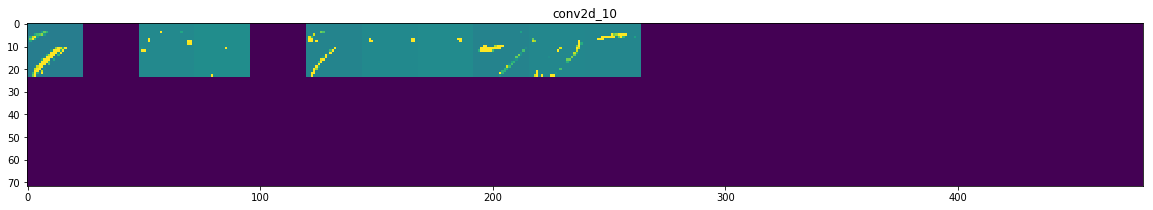

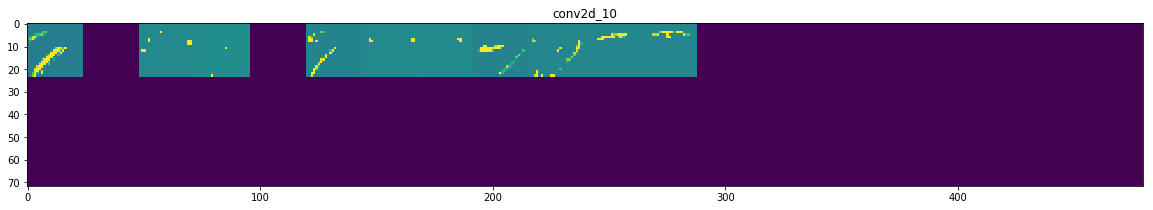

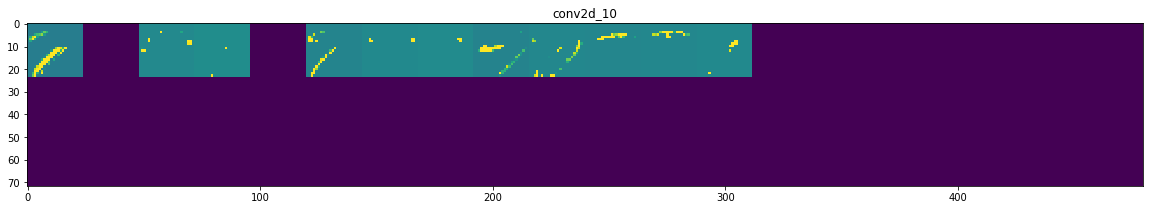

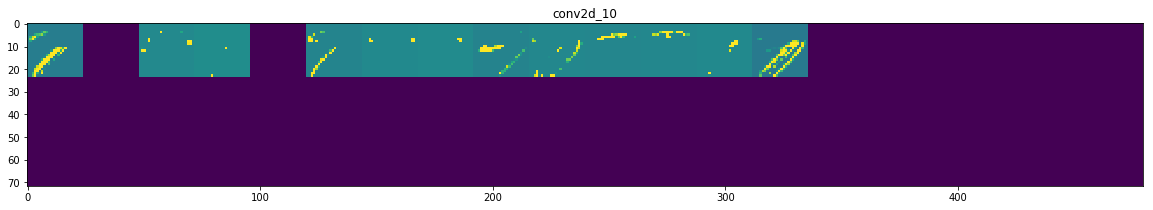

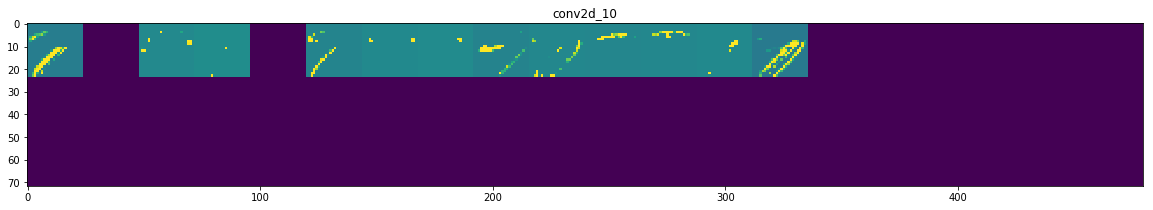

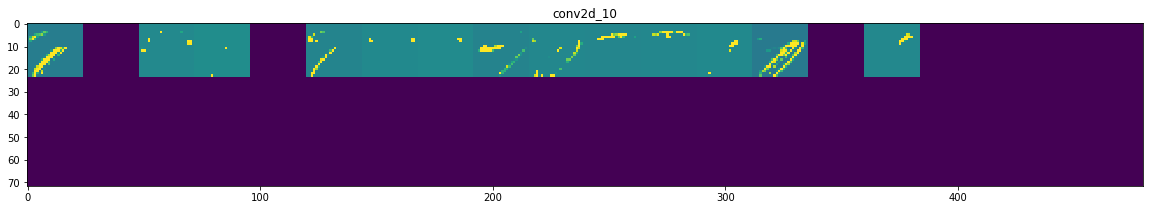

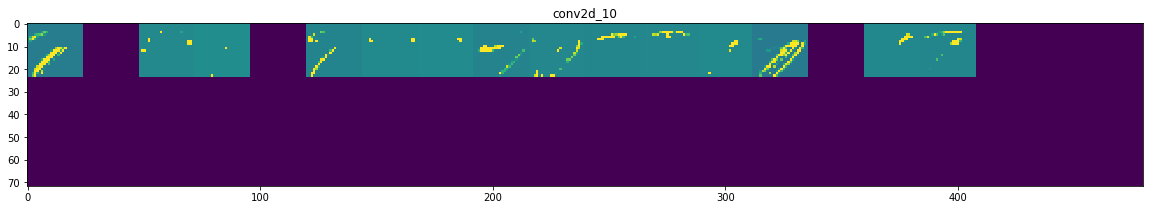

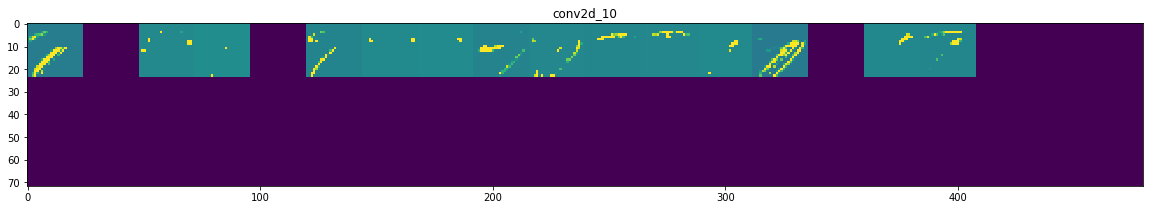

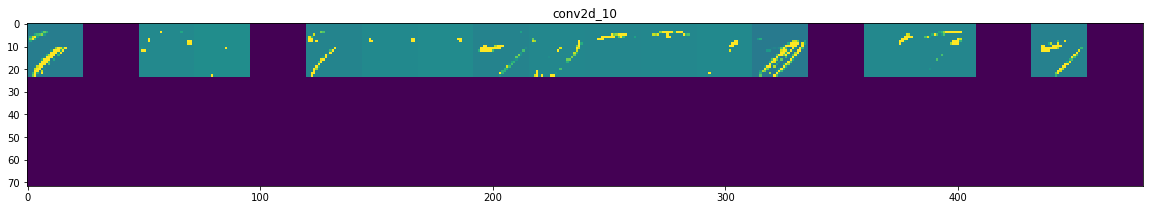

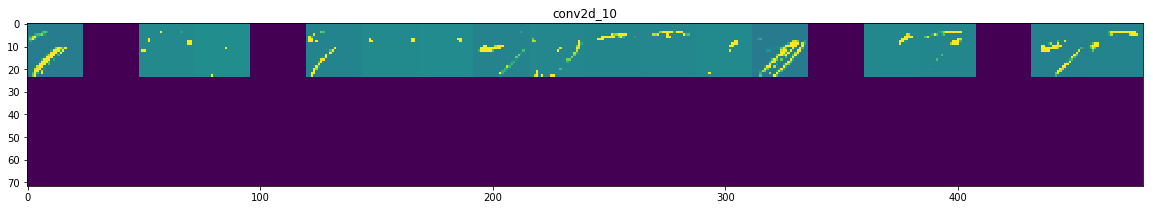

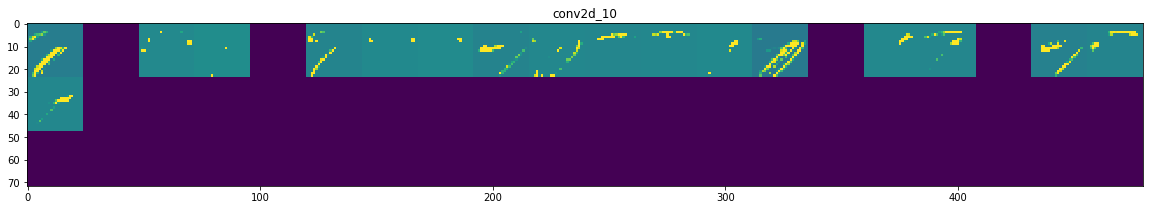

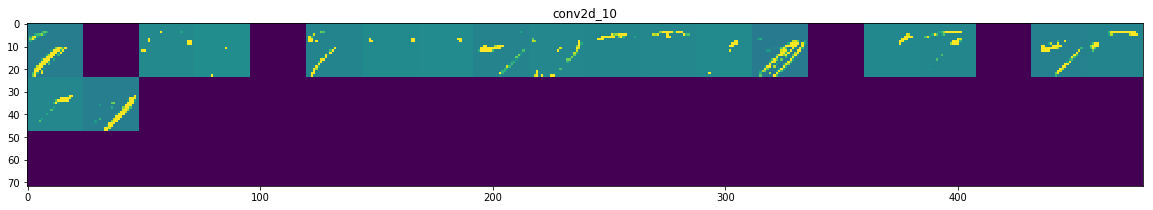

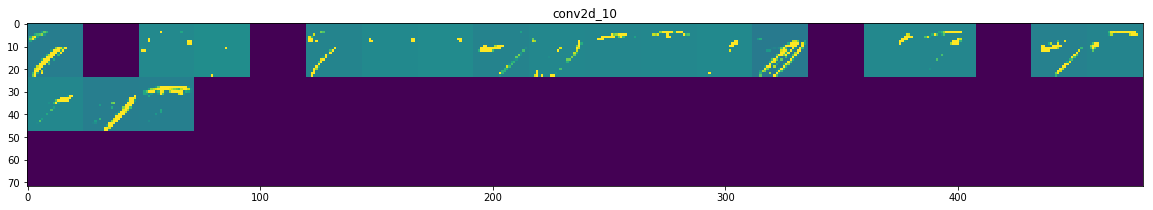

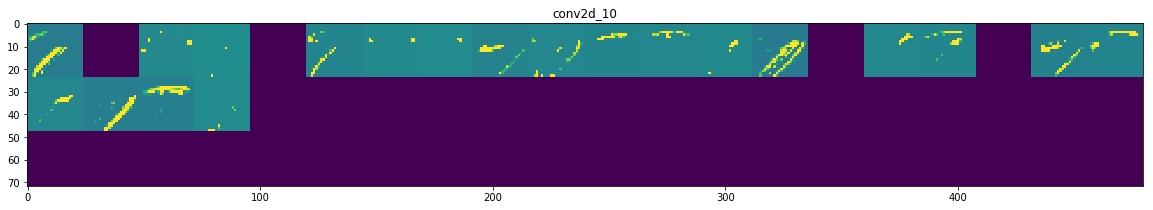

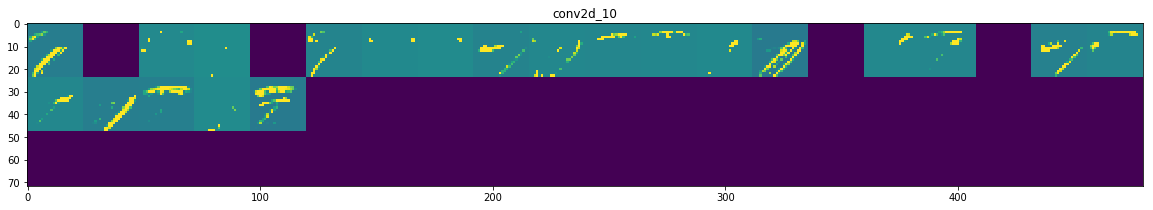

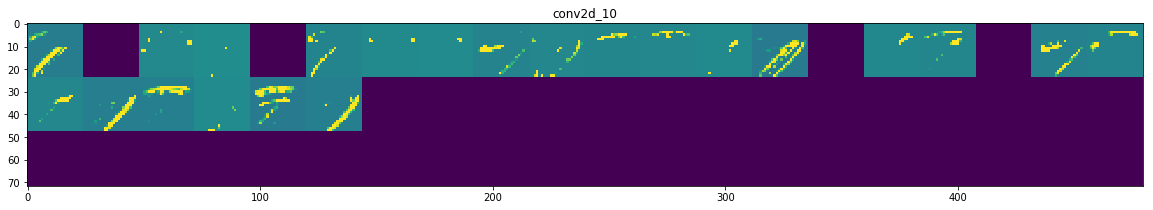

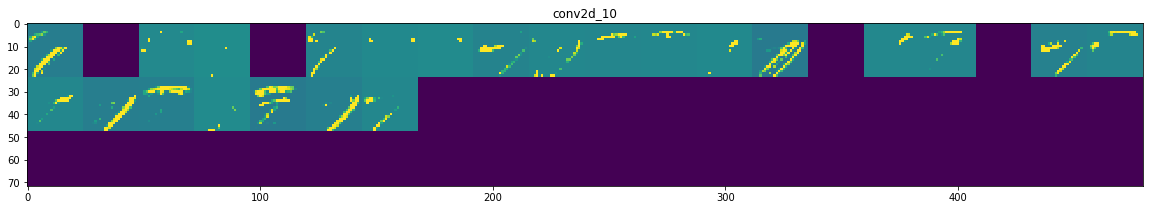

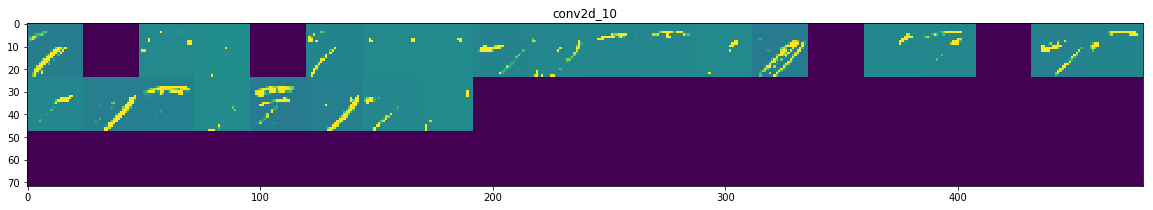

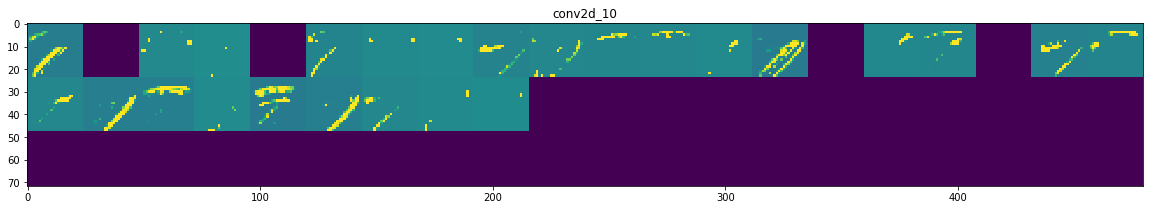

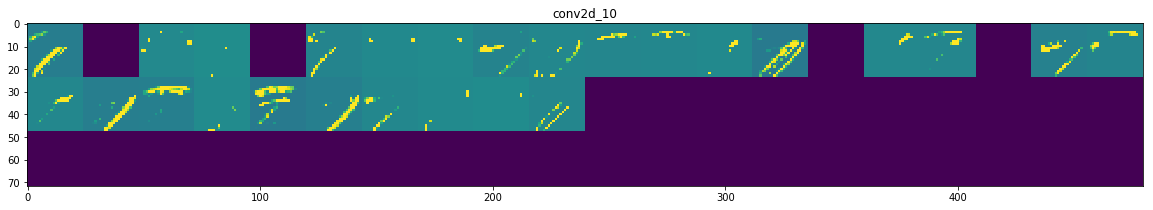

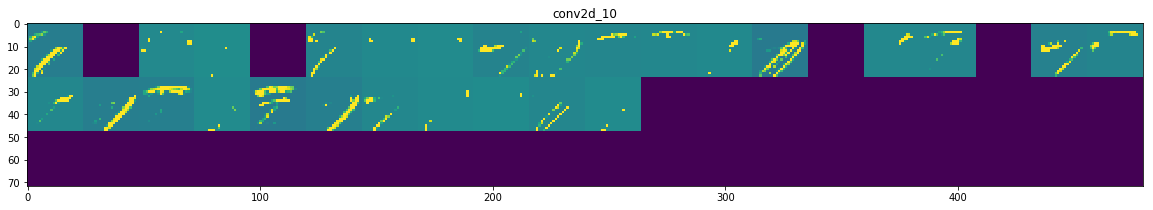

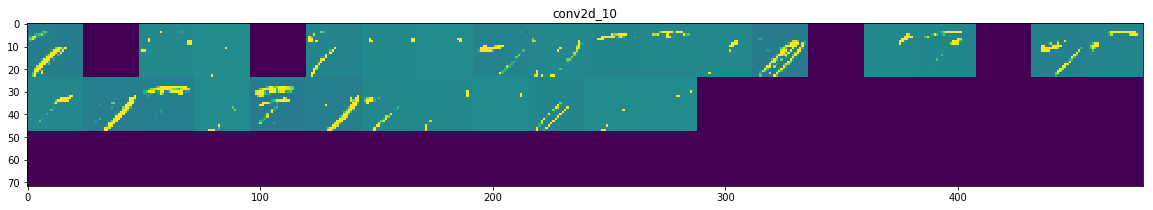

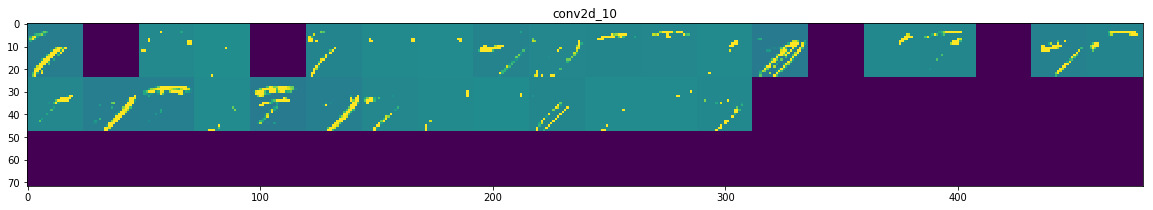

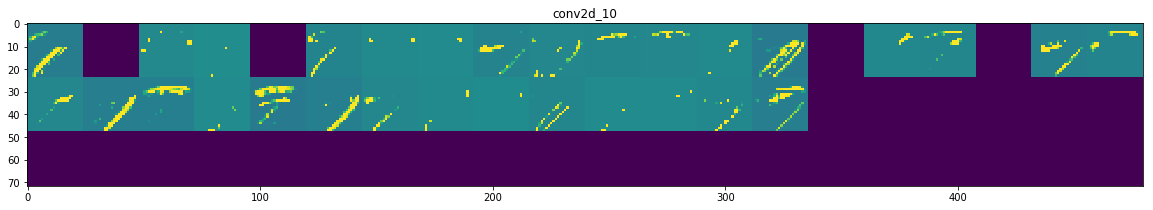

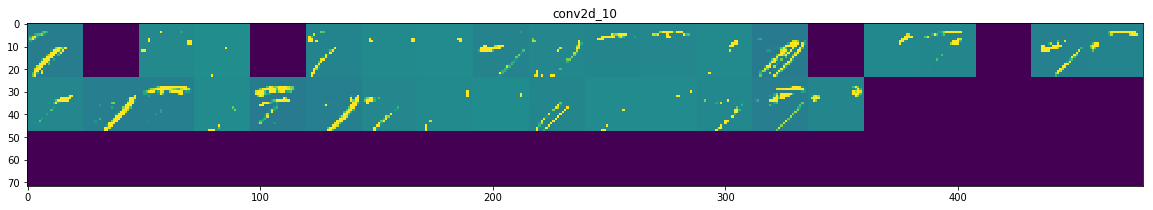

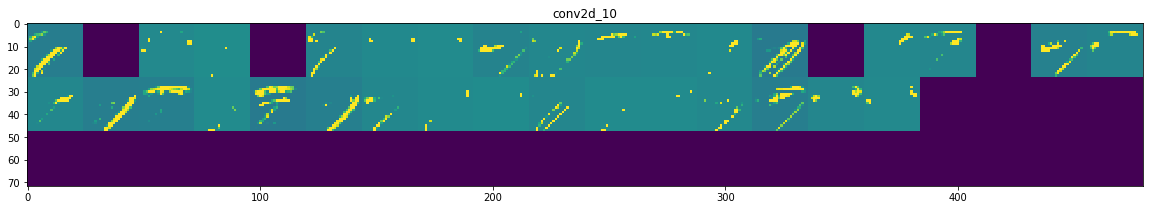

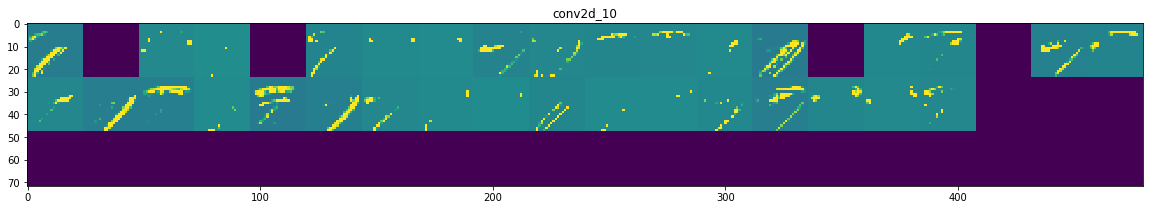

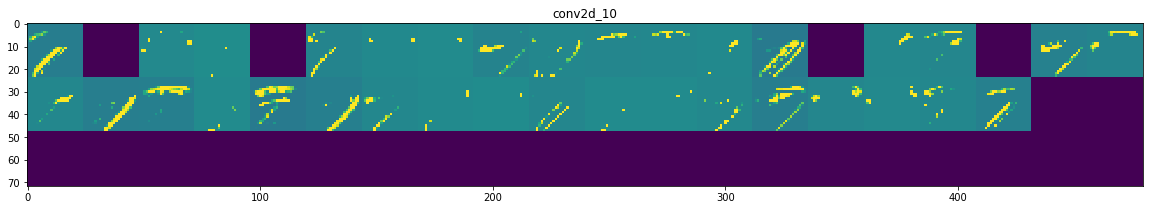

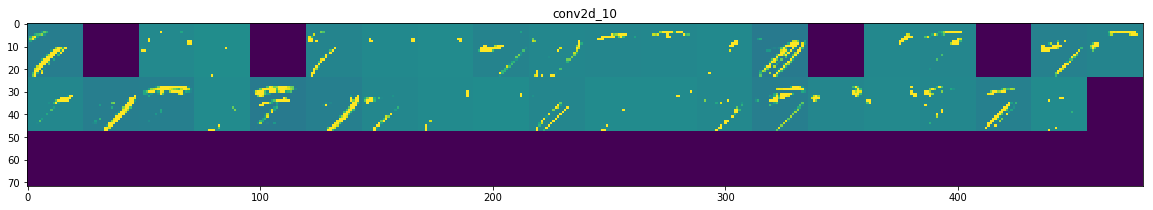

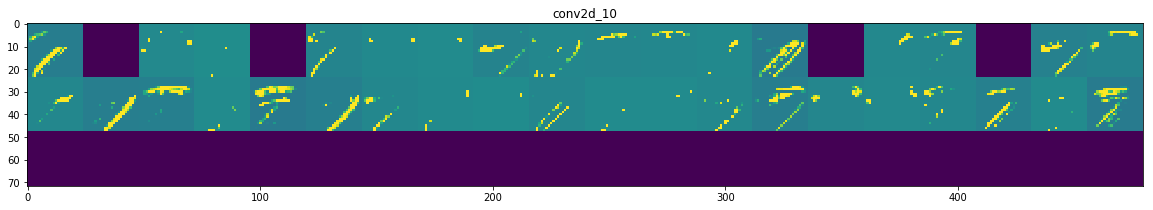

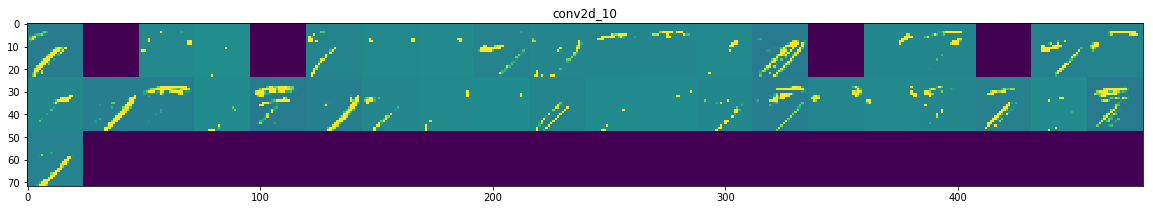

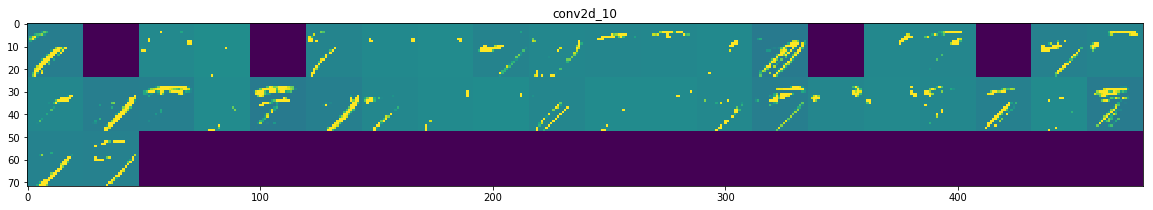

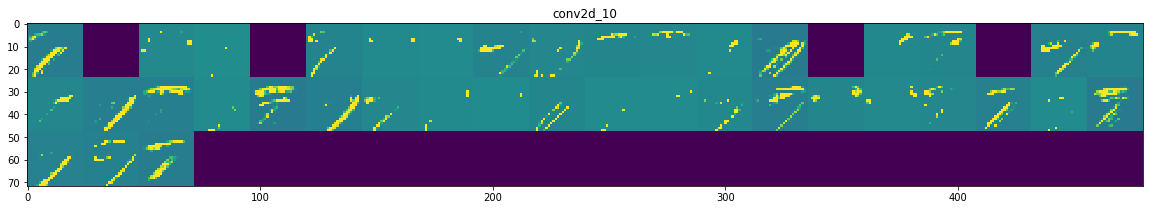

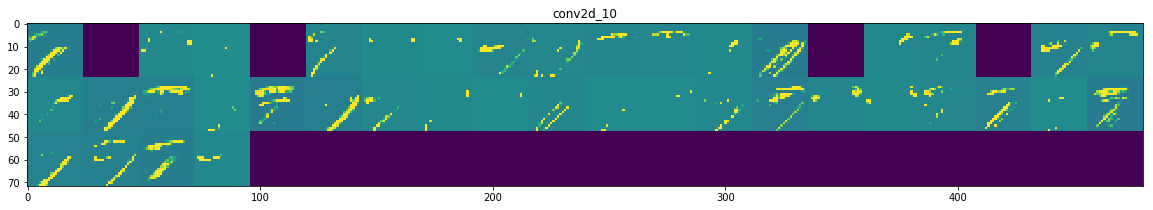

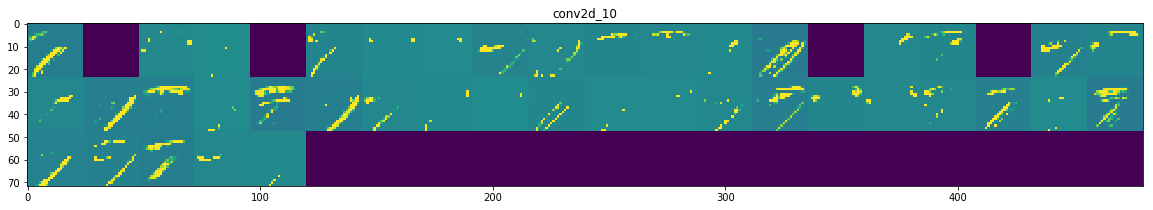

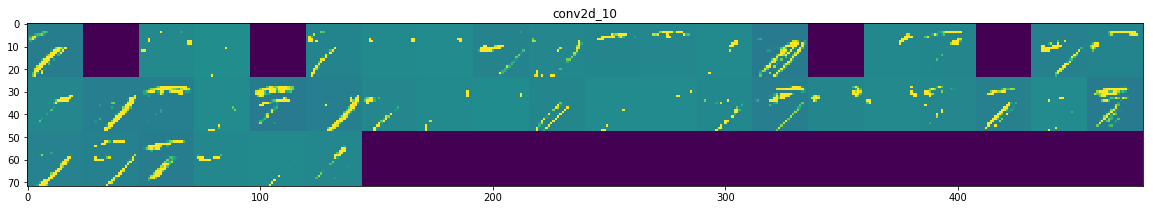

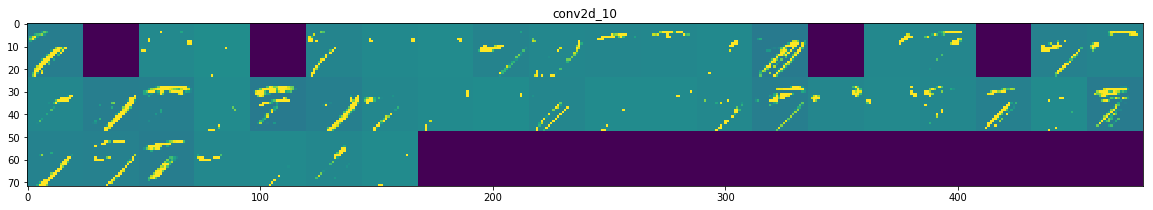

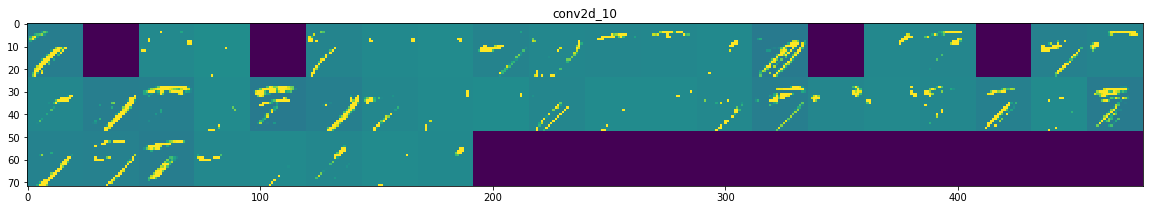

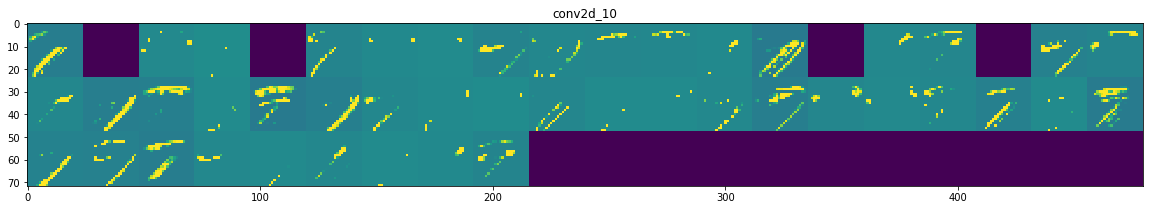

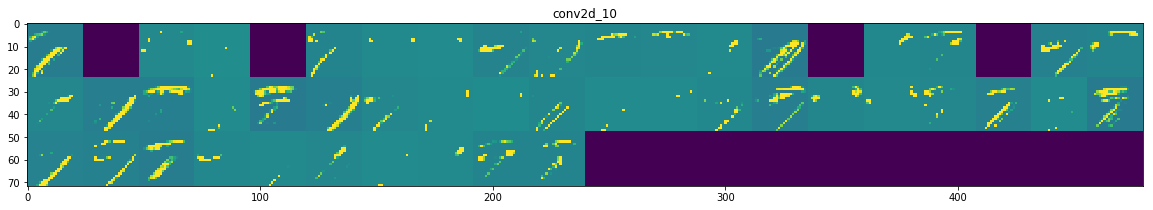

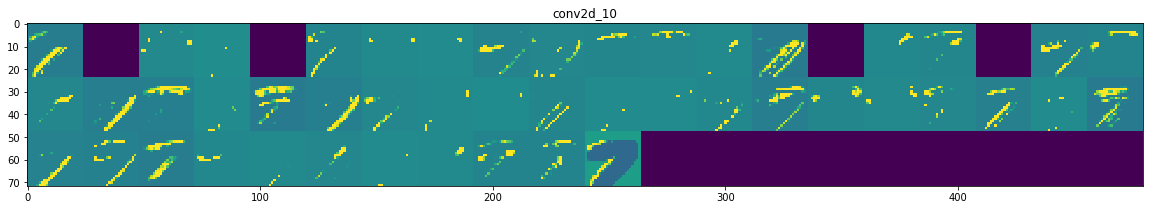

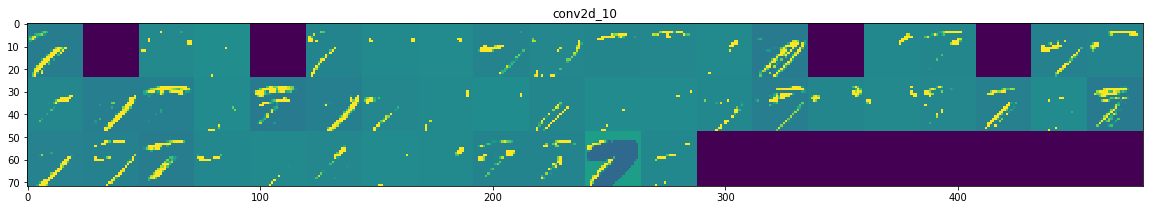

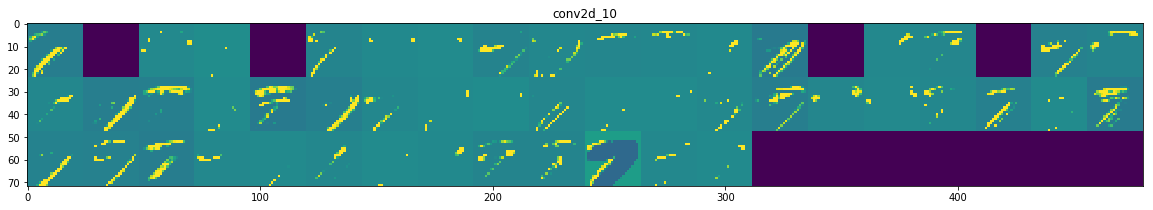

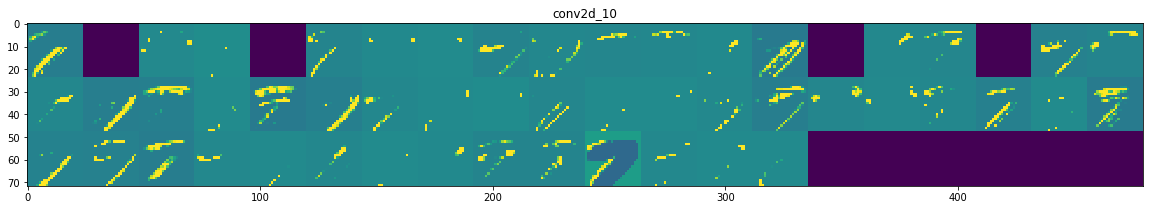

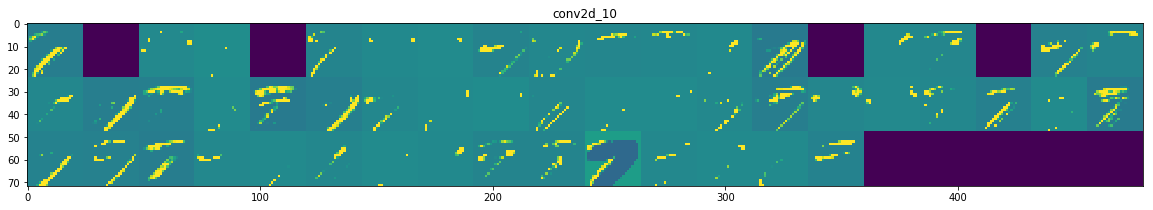

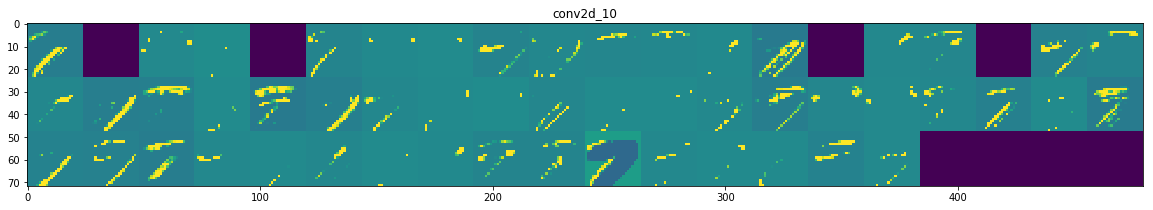

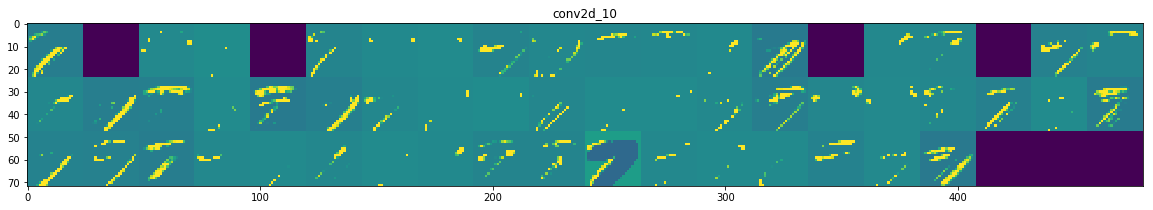

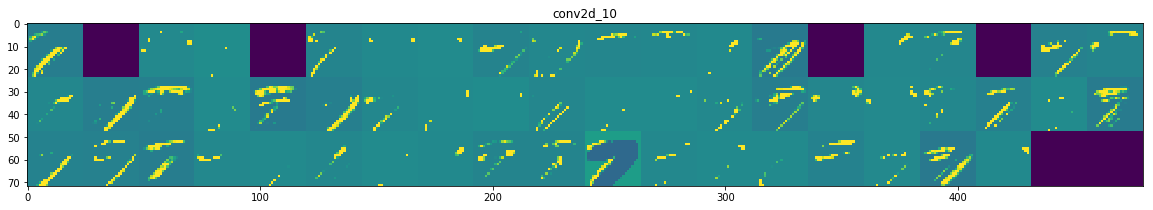

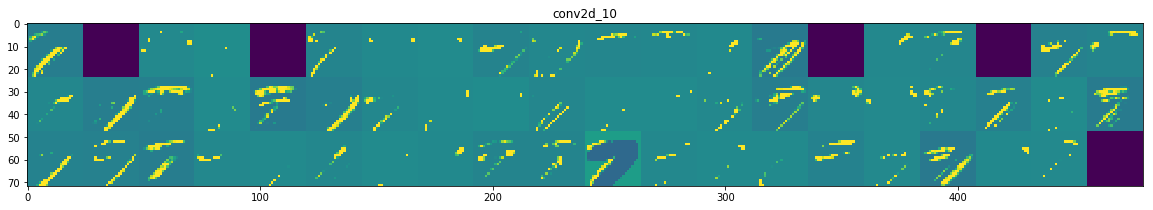

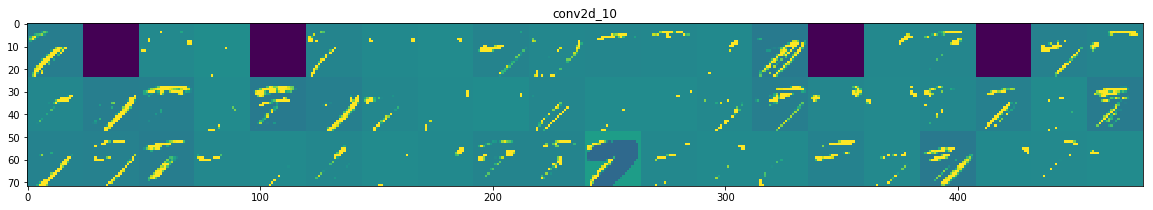

In [319]:
layer_names = []

for layer in model.layers[: -1]:
    layer_names.append(layer.name)
  
# conv layers 
images_per_row = 20
for layer_name, layer_activation in zip(layer_names, intermediate_output):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features// images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col* images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
                scale = 1. /size
                plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
                plt.title(layer_name)
                plt.grid(False)
                plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

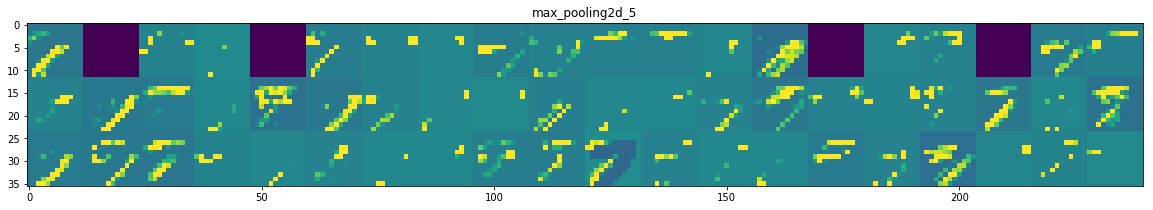

In [323]:
layer_names = []

for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
    
# maxpooling layers 
images_per_row = 20
for layer_name, layer_activation in zip(layer_names, intermediate_output):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')